#### **Learning Objectives**
- Use single- and multi-qubit gates in PennyLane.
- Implement inverse operations and custom controlled gates.
- Construct arbitraty gates from a unitary matrix or extract the matrix of a gate or circuit.

In [1]:
import pennylane as qml
from pennylane import numpy as np

### Quantum State Preparation
Before you can build gates into your circuits and measure their outputs to run powerful quantum algorithms, you might want to perform quantum state preparation, where you set the initial state of the qubits in your circuit.

In PennyLane, each qubit starts by default in the $\ket{0}$ state, which can also be written as the statevector 
$$
\begin{pmatrix}
1 \\
0
\end{pmatrix}
$$
 If this is the state you want — or if the initial state does not matter for your circuit or algorithm — you can continue with setting up your QNode as described in the previous module.

However, if you would like the input state of your circuit to be a specific state $\ket{\psi}$, you can prepare it by using `qml.StatePrep` and initialize it using a normalized 2-dimensional state vector. If you need to perform quantum state preparation for circuits with *n* qubits,  you can encode the desired state using the corresponding $2^{n}$-dimensional statevector.

To use `qml.StatePrep`, simply include it at the start of the your circuit.

In [ ]:
dev = qml.device("default.qubit")

@qml.qnode(dev)
def circuit(state = None):
    qml.StatePrep(state, wires = range(2), normalize = True) # Remember, the state in which you hae prepared your qubits in, should be normalized. Otherwise, we can use normalize = True argument.
    return qml.state()
state = circuit([1/2,1/2,1/2,1/2]) # It will be prepared as 0.5|00> + 0.5|01> + 0.5|10> + 0.5|11>
print(state)

[0.5547002+0.j 0.2773501+0.j 0.5547002+0.j 0.5547002+0.j]


For simpler applications, PennyLane also offers `qml.BasisState`, which performs state preparation into the computational basis and can be called via an `np.array` with a binary shape input or state enumeration.

In [3]:
@qml.qnode(dev)
def circuit_1(state = None):
    qml.BasisState(np.array([1,0,0]), wires = range(3)) # or we can also use np.array(4) which also means the prob of state |100> is 1 and 0 for rest of the states.
    # Remember, if you use `wires = 2` in the argument of BasisState/StatePrep, it will consider only 2nd wire, so you must have to ention `range(2)` or `[0,1,2]` if you want to apply the state to all wires/qubits
    return qml.state()
print(circuit_1()) # The result will be all zeros except at the 4th place for |100>

[0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]


#### **Problem**:
Prepare the state, 
$$
\ket{\psi} = \alpha \ket{001} + \beta \ket{010} + \gamma \ket{100}
$$ 

In [4]:
@qml.qnode(dev)
def prep_circuit(alpha, beta, gamma):
    """
    Prepares the state alpha|001> + beta|010> + gamma|100>.
    Args:
    alpha, beta, gamma (np.complex): The coefficients of the quantum state
    to prepare.
    Returns:
    (np.array): The quantum state
    """

    ####################
    qml.StatePrep(np.array([0, alpha, beta, 0, gamma, 0, 0, 0]), wires = range(3) , normalize = True)
    ####################
    
    return qml.state()

alpha, beta, gamma = 1/np.sqrt(3), 1/np.sqrt(3), 1/np.sqrt(3),
print("The prepared state is", prep_circuit(alpha, beta, gamma))

The prepared state is [0.        +0.j 0.57735027+0.j 0.57735027+0.j 0.        +0.j
 0.57735027+0.j 0.        +0.j 0.        +0.j 0.        +0.j]


### Single Qubit Gates
Now that we know how to prepare quantum states, let's apply unitaries! To begin with, let's focus on single qubit-unitaries. We already learned how to implement the Pauli, Hadamard, and Rotation gates. But PennyLane includes a wide array of built-in gates for you to use. Use the table below as a reference for the most common single-qubit gates.
| Gate | Matrix | Function / Description | PennyLane Function |
|------|--------|--------------------------|--------------------|
| X | $\begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix}$ | Bit flip: swaps \|0⟩ and \|1⟩ | `qml.X` or `qml.PauliX` |
| H | $\frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}$ | Creates superposition | `qml.Hadamard` |
| Z | $\begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix}$ | Phase flip: flips sign of \|1⟩ | `qml.Z` or `qml.PauliZ` |
| S | $\begin{bmatrix} 1 & 0 \\ 0 & i \end{bmatrix}$ | Adds 90° phase to \|1⟩; \( S^2 = Z \) | `qml.S` |
| T | $\begin{bmatrix} 1 & 0 \\ 0 & e^{i\pi/4} \end{bmatrix}$ | Adds 45° phase to \|1⟩; \( T^2 = S \) | `qml.T` |
| Y | $\begin{bmatrix} 0 & -i \\ i & 0 \end{bmatrix}$ | Bit & phase flip | `qml.Y` or `qml.PauliY` |
| RZ | $\begin{bmatrix} e^{-i\theta/2} & 0 \\ 0 & e^{i\theta/2} \end{bmatrix}$ | Rotation around Z-axis by θ | `qml.RZ(theta)` |
| RX | $\begin{bmatrix} \cos(\theta/2) & -i\sin(\theta/2) \\ -i\sin(\theta/2) & \cos(\theta/2) \end{bmatrix}$ | Rotation around X-axis by θ | `qml.RX(theta)` |
| RY | $\begin{bmatrix} \cos(\theta/2) & -\sin(\theta/2) \\ \sin(\theta/2) & \cos(\theta/2) \end{bmatrix}$ | Rotation around Y-axis by θ | `qml.RY(theta)` |


### Multi-Qubit Gates
Of course, to program interesting quantum algorithms, we also need multi-qubit gates. We have learned how to apply the CNOT gate in PennyLane (the only one we need, in principle). There are many more multi-qubit gates already implemented in PennyLane. Use this list as a reference!


| Gate   | Matrix Representation | Function / Description | PennyLane Function |
|--------|------------------------|-------------------------|---------------------|
| **CNOT** | $ \begin{bmatrix}1 & 0 & 0 & 0\\ 0 & 1 & 0 & 0\\ 0 & 0 & 0 & 1\\ 0 & 0 & 1 & 0\end{bmatrix} $ | Flips target qubit if control is $\lvert 1 \rangle$ | `qml.CNOT(wires=[control, target])` |
| **CZ** | $ \begin{bmatrix}1 & 0 & 0 & 0\\ 0 & 1 & 0 & 0\\ 0 & 0 & 1 & 0\\ 0 & 0 & 0 & -1\end{bmatrix} $ | Applies Z to target if control is $\lvert 1 \rangle$ | `qml.CZ(wires=[control, target])` |
| **CRZ** | $ \begin{bmatrix}1 & 0 & 0 & 0\\ 0 & 1 & 0 & 0\\ 0 & 0 & e^{-\frac{\iota \theta}{2}} & 0\\ 0 & 0 & 0 & e^{\frac{\iota \theta}{2}} \end{bmatrix} $ | Applies $R_z(\theta)$ to target if control is $\lvert 1 \rangle$ | `qml.CRZ(theta, wires=[control, target])` |
| **CRX** | $ \begin{bmatrix}1 & 0 & 0 & 0\\ 0 & 1 & 0 & 0\\ 0 & 0 & \cos\frac{\theta}{2} & -i\sin\frac{\theta}{2}\\ 0 & 0 & -i\sin\frac{\theta}{2} & \cos\frac{\theta}{2} \end{bmatrix} $ | Applies $R_x(\theta)$ to target if control is $\lvert 1 \rangle$ | `qml.CRX(theta, wires=[control, target])` |
| **CRY** | $ \begin{bmatrix}1 & 0 & 0 & 0\\ 0 & 1 & 0 & 0\\ 0 & 0 & \cos\frac{\theta}{2} & -\sin\frac{\theta}{2}\\ 0 & 0 & \sin\frac{\theta}{2} & \cos\frac{\theta}{2} \end{bmatrix} $ | Applies $R_y(\theta)$ to target if control is $\lvert 1 \rangle$ | `qml.CRY(theta, wires=[control, target])` |
| **CU** | $ \begin{bmatrix} I & 0 \\ 0 & U \end{bmatrix} $ | Applies single-qubit unitary $U$ if control is $\lvert 1 \rangle$ | `qml.ControlledQubitUnitary(U, control_wires=[...], wires=target)` |
| **SWAP** | $ \begin{bmatrix}1 & 0 & 0 & 0\\ 0 & 0 & 1 & 0\\ 0 & 1 & 0 & 0\\ 0 & 0 & 0 & 1\end{bmatrix} $ | Swaps the states of two qubits | `qml.SWAP(wires=[q1, q2])` |
| **Toffoli (CCX)** | $ \begin{bmatrix}1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\ 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\ 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\ 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0\\ 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\ 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\ 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\end{bmatrix} $ | Flips target if both controls are $\lvert 1 \rangle$ | `qml.Toffoli(wires=[control1, control2, target])` |
| **CCZ** | $ \begin{bmatrix}1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\ 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\ 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\ 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0\\ 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\ 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\ 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & -1\end{bmatrix} $ | Applies Z to target if both controls are $\lvert 1 \rangle$ | `qml.CCZ(wires=[control1, control2, target])` |


What happens if the unitary we want to apply isn't one of these? Then we can use `qml.QubitUnitary` to apply any unitary whose matrix we know! In circuits that we'd like to run on hardware, the use of this function is not encouraged, since quantum devices use a specific set of universal gates.

In the example below, we implement a unitary single-qubit unitary U on wire = 0 and a two-qubit unitary V on wires = [0,1].

In [5]:
@qml.qnode(dev)
def apply_unitaries(U,V):
    qml.QubitUnitary(U, wires = [0])
    qml.QubitUnitary(V, wires = [0,1])
    return qml.state()
U = np.array([[-0.69165024-0.50339329j,  0.28335369-0.43350413j],
       [ 0.1525734 -0.4949106j , -0.82910055-0.2106588j ]])
V = np.array([[-0.01161649+0.12340198j,  0.24202953+0.47179157j,
        -0.66720111+0.23783294j,  0.38909577-0.22439714j],
       [-0.47281374+0.235468j  , -0.51436345+0.28615452j,
         0.34116689+0.18781118j,  0.08677015-0.46405913j],
       [-0.53198348+0.60728927j,  0.34990852-0.34440384j,
         0.00247372-0.07165224j,  0.18828175+0.257979j  ],
       [-0.07641446-0.2190734j ,  0.27910452-0.23115134j,
         0.03829659-0.58309818j,  0.21999088-0.65189823j]])
print(apply_unitaries(U,V))

[ 0.08606318+0.28698854j  0.59055748-0.06504235j  0.63856782-0.16439135j
 -0.34016643+0.08207004j]


(<Figure size 500x300 with 1 Axes>, <Axes: >)

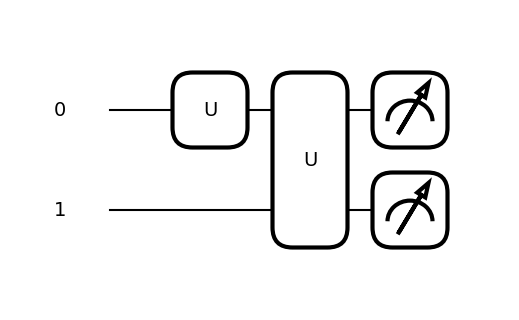

In [6]:
qml.draw_mpl(apply_unitaries)(U,V)

### Controlled Unitaries
The most common multi-qubit gates are the so-called controlled gates. These are gates of the form


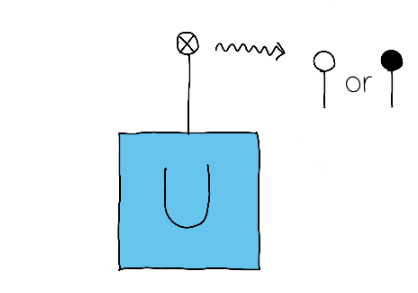


The black dot in the control wires means that this qubit acts as a control with `control_value = 1`, while a clear dot means that the qubit controls with `control_value = 0`. The gate U is only applied when
- The states in the wires with `control_value = 1` are equal to $\ket{1}$ and
- The states in the wires with `control_value = 0` are equal to $\ket{0}$.

Let's look at a simple example. Suppose that we want to apply the gate U controlled on the first wire with `control_value=1`, namely

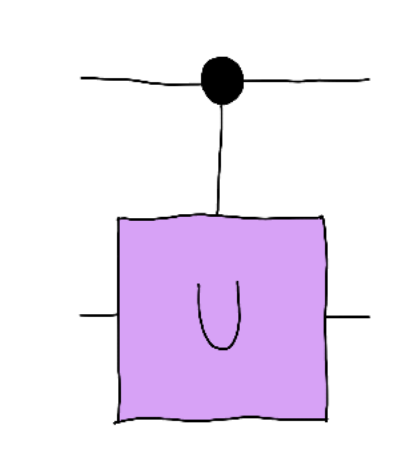

If **the gate** U **exists as a PennyLane operator, we can use the `qml.ctrl` function, which takes the following arguments**:
- `op` : U as a PennyLane operator of the form `qml.***` or a quantum function.
- `control` : the list of the wires that act as control.
- `control_values` : a list containing the control values assigned to each of the `control_wires`.

Then, `qml.ctrl(op, control_wires, control_values)` acts as a wrapper function that takes the *parameters* of `op` and the `wires` on which it acts.

For example, if U = RX($\theta$), the circuit that applies such gate is the following...

In [7]:
@qml.qnode(dev)
def controlled_rotationX(angle):
    qml.PauliX(wires = [0])
    qml.ctrl(qml.RX, control = (0), control_values = (1))(angle, wires = [1]) # here control represents the controlled_qubit and control_values represents the value of the controlled qubit on which gate is applied
    return qml.state()
angle = 0.5
print(controlled_rotationX(angle))

[0.        +0.j         0.        +0.j         0.96891242+0.j
 0.        -0.24740396j]


Do note that the `op` argument of `qml.ctrl` can also be a quantum function defined by the user!

If, instead, we are given the matrix U of the controlled unitary to be applied, we can use `qml.ControlledQubitUnitary`, which takes in three mandatory arguments:
- `U` : The matrix (`np.array`) of the Unitary U.
- `wires` : The list of wires in the following order (controlled wires, target_wire on which U will be applied).
- `control_values` : A list of the control values for the control wires.
Note that, unlike `qml.ctrl`, `qml.ControlledQubitUnitary` does not act as wrapper. Consider we want to apply the following


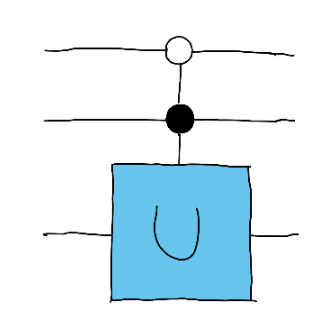

where 
$$
U = 
\begin{pmatrix}
0.94877869 & 0.31594146 \\
-0.31594146 & 0.94877869
\end{pmatrix}
$$

In [8]:
unitary = np.array([
    [0.94877869, 0.31594146],
    [-0.31594146, 0.94877869]
])
@qml.qnode(dev)
def controlled_unitary():
    qml.X(wires = [1])
    qml.ControlledQubitUnitary(unitary, wires = (0,1,2), control_values= (0,1))
    return qml.state()
print(controlled_unitary())

[ 0.        +0.j  0.        +0.j  0.94877869+0.j -0.31594146+0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]


Lets, Implement the following Circuit : 

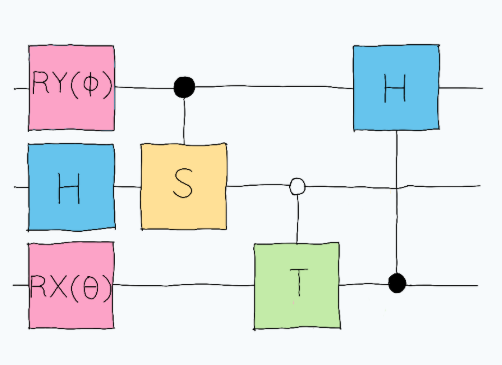



[ 0.67743133+0.j          0.09955974-0.09955974j  0.67743133+0.j
  0.01848579-0.12231294j  0.10238373+0.j          0.07341688-0.07341688j
  0.        +0.10238373j -0.01848579-0.12231294j]


(<Figure size 700x400 with 1 Axes>, <Axes: >)

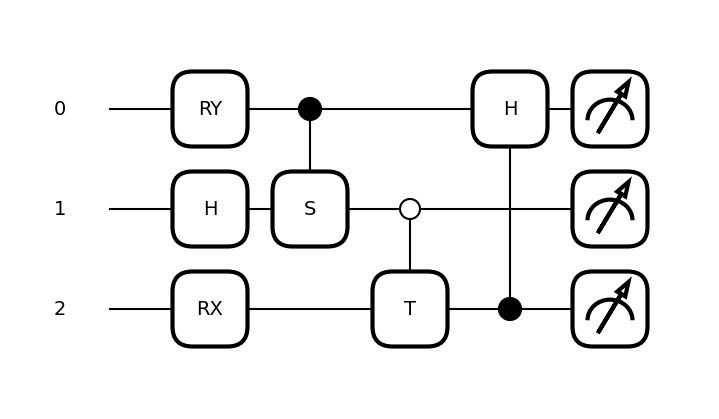

In [9]:
@qml.qnode(dev)
def ctrl_circuit(theta,phi):
    qml.RY(phi, wires = [0])
    qml.Hadamard(wires = [1])
    qml.RX(theta, wires = [2])
    qml.ctrl(qml.S, control = [0], control_values = [1])(wires = [1])
    qml.ctrl(qml.T, control = [1], control_values = [0])(wires = [2])
    qml.ctrl(qml.Hadamard, control = [2], control_values = [1])(wires = [0])
    
    return qml.state()
theta = 0.5
phi = 0.3
print(ctrl_circuit(theta, phi))
qml.draw_mpl(ctrl_circuit)(theta,phi)

### Inverse Operations
In many quantum algorithms, we need to apply the inverse of an operator U. We can do this in PennyLane by using the `qml.adjoint` function, which acts on a quantum gate or quantum function. If it acts on a gate, we may use it as a function or wrapper. For example : 

`qml.adjoint(qml.RX(theta, wires = [0]))` and `qml.adjoint(qml.RX)(theta, wires = [0])` will yield the same output. However, if the argument of `qml.adjoint` is a quantum function, you must use it as a wrapper.

Let's measure the followign pattern, which is the most useful in many quantum algorithms: named as phase kickback.

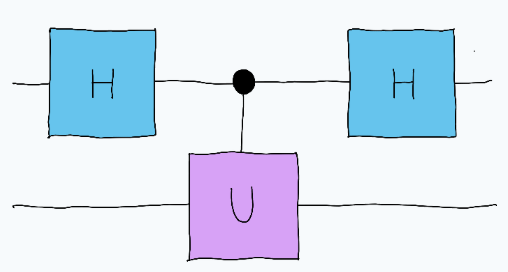



[ 0.15417488-0.25169664j  0.0762867 -0.2474553j   0.84582512+0.25169664j
 -0.0762867 +0.2474553j ]


(<Figure size 600x300 with 1 Axes>, <Axes: >)

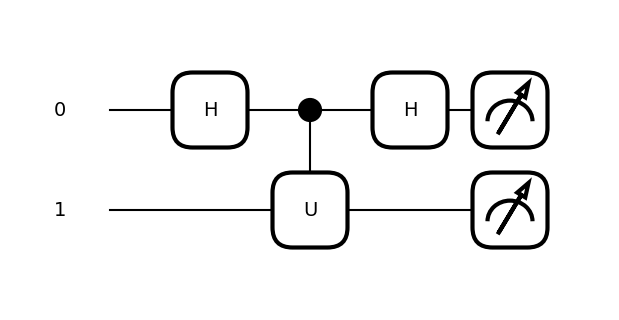

In [13]:
# The famous phase kickback Effect (Note : matrix is arbitrary)
@qml.qnode(dev)
def phase_kickback(matrix):
    qml.Hadamard(wires = [0])
    qml.ControlledQubitUnitary(matrix, wires = [0,1], control_values = [1])
    qml.Hadamard(wires = [0])
    return qml.state()
matrix = np.array([
    [-0.69165024-0.50339329j,  0.28335369-0.43350413j],
    [ 0.1525734 -0.4949106j , -0.82910055-0.2106588j]
    ])
print(phase_kickback(matrix))
qml.draw_mpl(phase_kickback)(matrix)

Lets solve another problem which is also quite usefull in quantum algorithms. It is `Do, apply, Undo`.


The output state is: 
 [ 0.9842122+0.j          0.       +0.j          0.       +0.j
  0.       -0.07788367j -0.0315756+0.j          0.       +0.j
  0.       +0.j          0.       -0.15576734j]


(<Figure size 600x400 with 1 Axes>, <Axes: >)

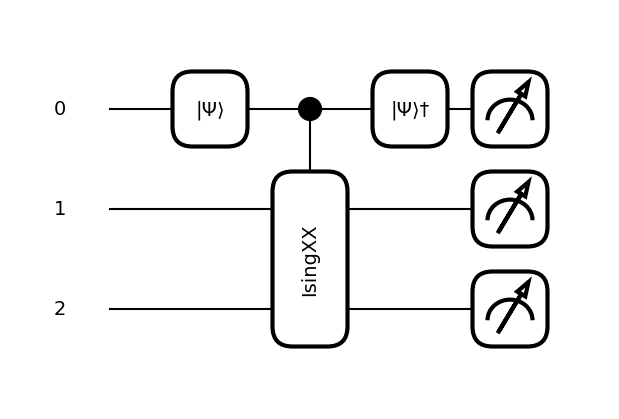

In [26]:
dev = qml.device("default.qubit")

def do(k):

    qml.StatePrep([1,k], wires = [0], normalize = True)

def apply(theta):

    qml.IsingXX(theta, wires = [1,2])

@qml.qnode(dev)
def do_apply_undo(k,theta):
    """
    Applies V, controlled-U, and the inverse of V
    Args: 
    - k, theta: The parameters for do and apply (V and U) respectively
    Returns:
    - (np.array): The output state of the routine
    """

    ####################
    do(k)
    qml.ctrl(apply, control = 0, control_values = 1)(theta)
    qml.adjoint(do)(k)
    ####################

    return qml.state()

k, theta = 0.5, 0.8

print("The output state is: \n", do_apply_undo(k, theta))
qml.draw_mpl(do_apply_undo)(k,theta)